# Simple Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, invgamma

In [2]:
# Simulate SLR Data
beta0_true = 1
beta1_true = 2
sigma_true = 3

n = 100
X = np.random.uniform(0, 10, n)
epsilon = np.random.normal(0, sigma_true, n)
y = beta0_true + beta1_true * X + epsilon

# Fit the model using OLS
X_reshaped = X.reshape(-1, 1)
model = LinearRegression()
model.fit(X_reshaped, y)
beta0_hat = model.intercept_
beta1_hat = model.coef_[0]
print(f"Estimated coefficients: beta0 = {beta0_hat:.2f}, beta1 = {beta1_hat:.2f}")


Estimated coefficients: beta0 = 1.12, beta1 = 2.08


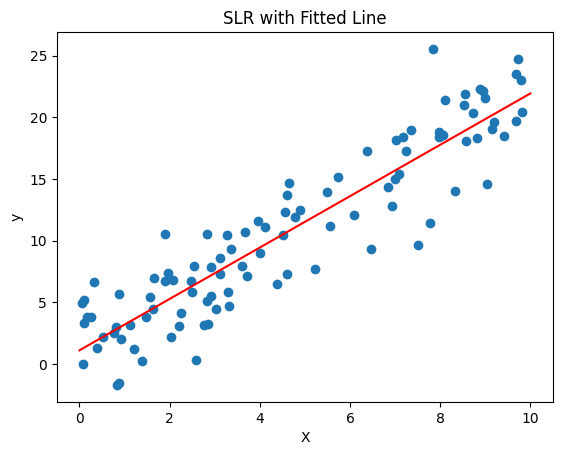

In [3]:
# Plot the regression line
plt.scatter(X, y)
x_vals = np.array([0, 10])
y_vals = beta0_hat + beta1_hat * x_vals
plt.plot(x_vals, y_vals, color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.title('SLR with Fitted Line')
plt.show()

# Bayesian Simple Linear Regression - MCMC

Likelihood: 

$P(Y | \beta_0, \beta_1, \sigma^2) = \prod_{i}^{n}N(y_i | \beta_0 + \beta_1 x_i, \sigma^2)$

Priors:

$\beta_0 \sim N(0,3^2)$
$\beta_1 \sim N(0,3^2)$
$\sigma^2 \sim InverseGamma(\alpha,\beta)$

In [4]:
# Beta0 prior: N(mu0, sigma0)
mu0 = 0
sigma0 = 8

# Beta1 prior: N(mu1, sigma1)
mu1 = 0
sigma1 = 8

# Sigma^2 prior: Inv-Gamma(alpha, beta)
alpha = 3
beta = 1

In [5]:
def log_posterior(y, X, beta0, beta1, sigma, mu0, sigma0, mu1, sigma1, alpha, beta):
    
    y_hat = beta0 + beta1 * X
    log_probs = norm.logpdf(y, loc=y_hat, scale=sigma)
    log_likelihood = np.sum(log_probs)
    log_prior = norm.logpdf(beta0, loc=mu0, scale=sigma0) + norm.logpdf(beta1, loc=mu1, scale=sigma1) + invgamma.logpdf(sigma, a=alpha, scale=beta)
    log_post = log_likelihood + log_prior

    return log_post

In [6]:
post_samples = 10000
burn_in = 1000
param_samples = np.zeros((post_samples, 3))
param_samples[0,:] = [1, 1, 1]

for i in range(1, post_samples):

    beta0_current, beta1_current, sigma_current = param_samples[i-1,:]

    # Simulate Beta0
    beta0_proposal = np.random.normal(beta0_current, 0.5)
    log_post = log_posterior(y, X, beta0_proposal, beta1_current, sigma_current, mu0, sigma0, mu1, sigma1, alpha, beta)
    log_post_current = log_posterior(y, X, beta0_current, beta1_current, sigma_current, mu0, sigma0, mu1, sigma1, alpha, beta)
    log_accept_ratio = log_post - log_post_current
    if np.log(np.random.uniform(0, 1)) < log_accept_ratio:
        beta0_current = beta0_proposal

    # Simulate Beta1
    beta1_proposal = np.random.normal(beta1_current, 0.5)
    log_post = log_posterior(y, X, beta0_current, beta1_proposal, sigma_current, mu0, sigma0, mu1, sigma1, alpha, beta)
    log_post_current = log_posterior(y, X, beta0_current, beta1_current, sigma_current, mu0, sigma0, mu1, sigma1, alpha, beta)
    log_accept_ratio = log_post - log_post_current
    if np.log(np.random.uniform(0, 1)) < log_accept_ratio:
        beta1_current = beta1_proposal

    # Simulate Sigma
    sigma_proposal = np.random.normal(sigma_current, 0.5)
    if sigma_proposal < 0:
        sigma_proposal = 0.1
    log_post = log_posterior(y, X, beta0_current, beta1_current, sigma_proposal, mu0, sigma0, mu1, sigma1, alpha, beta)
    log_post_current = log_posterior(y, X, beta0_current, beta1_current, sigma_current, mu0, sigma0, mu1, sigma1, alpha, beta)
    log_accept_ratio = log_post - log_post_current
    if np.log(np.random.uniform(0, 1)) < log_accept_ratio:
        sigma_current = sigma_proposal

    param_samples[i,:] = [beta0_current, beta1_current, sigma_current]

In [7]:
# Parameter Estimates
post_burnin_samples = param_samples[burn_in:,:]
post_mean = post_burnin_samples.mean(axis=0)
print(f"Posterior Means: beta0 = {post_mean[0]:.2f}, beta1 = {post_mean[1]:.2f}, sigma = {post_mean[2]:.2f}")

Posterior Means: beta0 = 1.17, beta1 = 2.07, sigma = 2.77


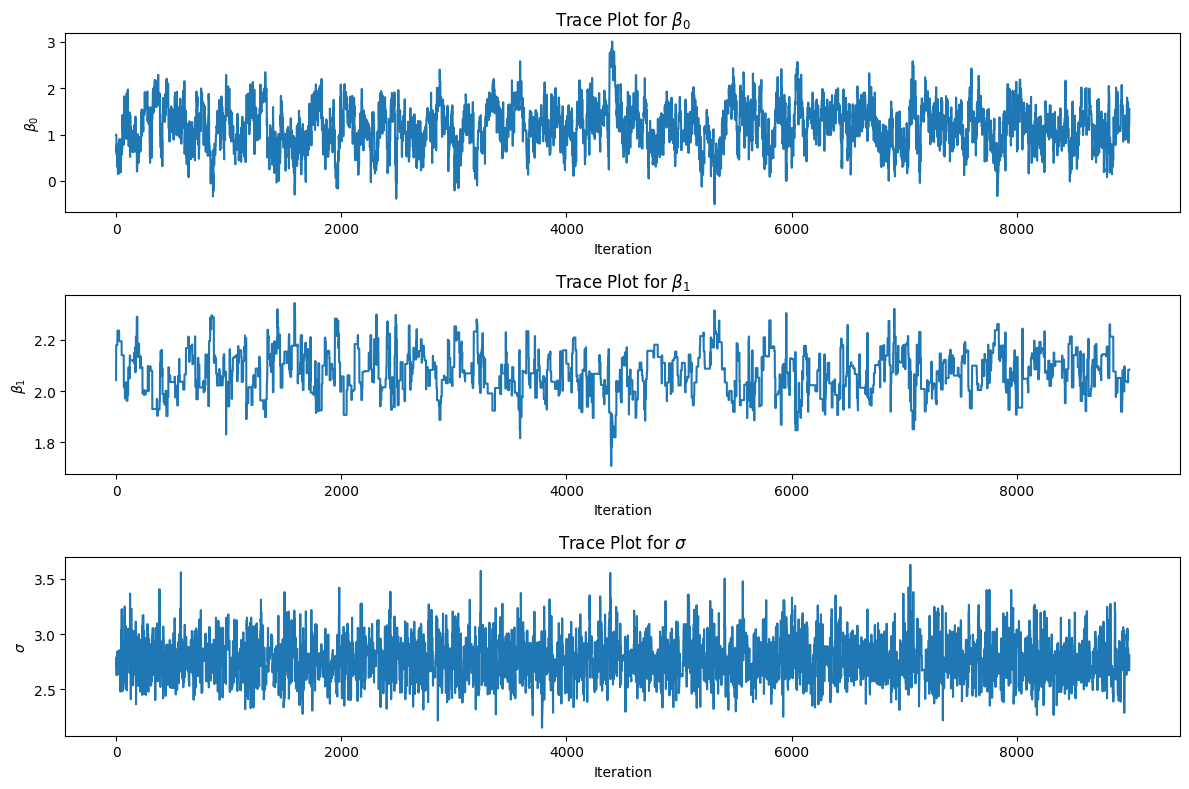

In [8]:
# Trace Plots
plt.figure(figsize=(12, 8))

# Plot for beta0
plt.subplot(3, 1, 1)
plt.plot(param_samples[burn_in:, 0])
plt.title("Trace Plot for $\\beta_0$")
plt.xlabel("Iteration")
plt.ylabel("$\\beta_0$")

# Plot for beta1
plt.subplot(3, 1, 2)
plt.plot(param_samples[burn_in:, 1])
plt.title("Trace Plot for $\\beta_1$")
plt.xlabel("Iteration")
plt.ylabel("$\\beta_1$")

# Plot for sigma
plt.subplot(3, 1, 3)
plt.plot(param_samples[burn_in:, 2])
plt.title("Trace Plot for $\\sigma$")
plt.xlabel("Iteration")
plt.ylabel("$\\sigma$")

plt.tight_layout()
plt.show()


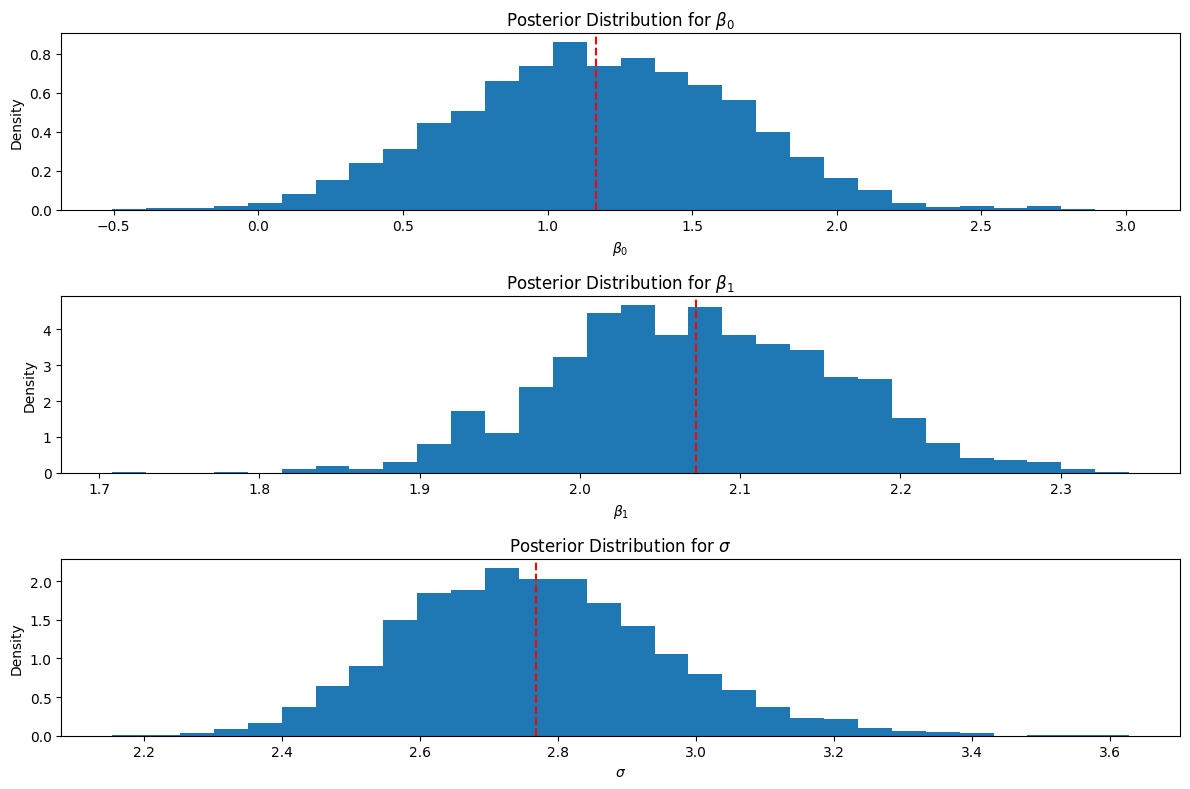

In [9]:
# Posterior Distributions
plt.figure(figsize=(12, 8))

# Plot for beta0
plt.subplot(3, 1, 1)
plt.hist(param_samples[burn_in:, 0], bins=30, density=True)
plt.title("Posterior Distribution for $\\beta_0$")
plt.xlabel("$\\beta_0$")
plt.ylabel("Density")
plt.axvline(x=param_samples[burn_in:, 0].mean(), color='red', linestyle='--', label='Posterior Mean')

# Plot for beta1
plt.subplot(3, 1, 2)
plt.hist(param_samples[burn_in:, 1], bins=30, density=True)
plt.title("Posterior Distribution for $\\beta_1$")
plt.xlabel("$\\beta_1$")
plt.ylabel("Density")
plt.axvline(x=param_samples[burn_in:, 1].mean(), color='red', linestyle='--', label='Posterior Mean')

# Plot for sigma
plt.subplot(3, 1, 3)
plt.hist(param_samples[burn_in:, 2], bins=30, density=True)
plt.title("Posterior Distribution for $\\sigma$")
plt.xlabel("$\\sigma$")
plt.ylabel("Density")
plt.axvline(x=param_samples[burn_in:, 2].mean(), color='red', linestyle='--', label='Posterior Mean')

plt.tight_layout()
plt.show()

In [10]:
df = pd.DataFrame({
    'Beta0': [beta0_true, post_mean[0]],
    'Beta1': [beta1_true, post_mean[1]],
    'Sigma': [sigma_true, post_mean[2]],
}, index=['True Values', 'MCMC Values'])

df

,Beta0,Beta1,Sigma
True Values,1.000000,2.000000,3.000000
MCMC Values,1.168761,2.072668,2.767355
